In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sys.path.append(os.getcwd() + '/../../')
from matplotlib.patches import Ellipse
from numpy.random import multivariate_normal as m_normal
import plda
from scipy.stats import norm, chi2


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
import numpy as np
#from PLDA import PLDA
from numpy.random import multivariate_normal as m_normal

from scipy.linalg import eig
from scipy.linalg import inv
from scipy.stats import linregress

In [40]:
def gen_Ψ(n_dims):
    """ Diagonal matrix describing the covariance between clusters.
    """
    Ψ = np.diag(10 / np.random.sample(n_dims))

    return Ψ

def gen_m(n_dims):
    """ Displacement of the mean of the data from the origin.
    """
    m = np.random.randint(-1000, 1000, n_dims).astype(float)

    return m

def gen_V(Ψ, n_classes, n_dims):
    """ v ~ N(0, Ψ): Consult Equations (2) on p. 533.

    DESCRIPTION: Samples whitened class centers from a multivariate
                  Gaussian distribution centered at 0, with covariance Ψ.
                  For testing purposes, we ensure that V.sum(axis=0) = 0. 

    PARAMETERS
     n_classes      (int): Number of classes.
     n_dims         (int): Dimensionality of the data.
     Ψ        (ndarray): Covariance between whitened class centers.
                            [n_dims x n_dims] 
    RETURNS
     V          (ndarray): Whitened class centers. [n_classes x n_dims] 
    """
    assert Ψ.shape[0] == Ψ.shape[1]

    μ = np.zeros(n_dims)  # [1 x n_dims] 
    np.random.seed(0)
    V = m_normal(μ, Ψ, n_classes)
    V = V - V.mean(axis=0)  # Center means at origin to control result.


    assert np.allclose(V.sum(axis=0), 0)

    return V

def gen_A(V, n_classes, n_dims, return_S_b=False):
    # XXX Where this eq come from
    """ A = [B][inv(Λ ** .5)][Q^T] and assumes same number of data
         in each class v. """
    
    
    #np.random.seed(2018)
    B = np.random.randint(-20, 20, (n_dims, n_dims)).astype(float)
    big_V = np.matmul(V.T, V)  # V is now a scatter matrix.
    vals, vecs = eig(big_V)
    A = B / np.sqrt(vals.real)
    A = np.matmul(A, vecs.T)
    
    # XXX It works as well does not need to be that eq. But Why is he doing that? !?
    #A = B
    
    D = np.matmul(np.matmul(vecs.T, big_V), vecs)
    assert np.allclose(D, np.diag(vals))
    
    if return_S_b is True:
        
        # XXX Where this eq come from
        S_b = 1 /n_classes * np.matmul(np.matmul(A, big_V), A.T)
        x = np.matmul(A, V.T).T

        S_b_empirical = 1 / n_classes * np.matmul(x.T, x)
        assert np.allclose(S_b, S_b_empirical)

        return A, S_b
    else:
        return A

def gen_U(n_dims, n, V):
    """ u ~ N(v, I). 533.
    """
    cov = np.eye(n_dims)

    U = []
    for v in V:
        μ = np.zeros(n_dims)
        U_for_class_v = m_normal(μ, cov, n)
        U_for_class_v -= U_for_class_v.mean(axis=0)
        U_for_class_v += v  # Center at v to control test results.
        U.append(U_for_class_v)

    # To control the test result, each set of u's sums to its respective v.
    for x in range(len(U)):
        are_same = np.allclose(V[x], U[x].mean(axis=0))
        assert are_same ==  True

    U = np.vstack(U)

    return U

def unwhiten(U, A, m):
    """ inv(A)[x - m]. See p. 537 Fig. 2.
    """
    X = np.matmul(A, U.T).T
    X += m

    return X

def gen_labels(n_classes, n):
    labels = []
    for x in range(n_classes):
        labels += [x] * n

    return labels

def label(data, labels):
        labeled_data = []
        for datum, label in zip(data, labels):
            labeled_data.append((datum, label))

def experiment(n, n_dims, n_classes):
    Ψ = gen_Ψ(n_dims)
    m = gen_m(n_dims)
    V = gen_V(Ψ, n_classes, n_dims)
    U = gen_U(n_dims, n, V)
    A,_b = gen_A(V, n_classes, n_dims,
                             return_S_b=True)
    X = unwhiten(U, A, m)
    Y = gen_labels(n_classes, n)
    labels = ([1] * 100) + ([2] * 100) + ([3] * 100)
    #laled_X = label(X, Y)
 
    model = plda.Classifier(X, np.array(labels))
    classifier.fit_model()

    return A, Ψ, model

In [41]:
n_dims = 2

Psi = gen_Ψ(n_dims)
m = gen_m(n_dims)

Psi
m

array([[250.04499622,   0.        ],
       [  0.        ,  15.63220288]])

array([-467.,  630.])

In [42]:
n = 100
n_classes = 3 

V = gen_V(Psi, n_classes, n_dims)
A, Sb = gen_A(V, n_classes, n_dims, return_S_b=True)
U = gen_U(n_dims, n, V)

V
V.shape

U.shape
A


array([[ 3.59377083, -0.61059323],
       [-8.82425686,  6.66723155],
       [ 5.23048603, -6.05663832]])

(3, 2)

(300, 2)

array([[ 16.,   3.],
       [-14.,   4.]])

In [43]:
Y = unwhiten(V, A, m)

Y

X = unwhiten(U, A, m)
X.shape

array([[-411.33144641,  577.24483548],
       [-588.18641514,  780.20852227],
       [-401.48213845,  532.54664224]])

(300, 2)

In [44]:
labeled_X = label(X, Y)
labeled_X


(-12.298935034916482, 9.051227209912945, -9.903545307369177, 9.937369614591542)

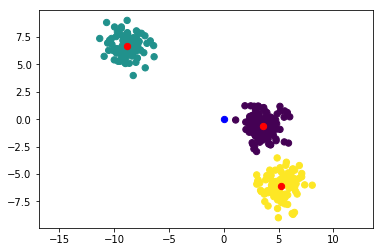

In [45]:
U_labels = ([1] * 100) + ([2] * 100) + ([3] * 100)

ax = plt.gca()
ax.scatter(U[:, 0], U[:, 1], c=U_labels, s=40, cmap='viridis', zorder=2)
ax.scatter(V[:, 0], V[:, 1], c='red', s=40, cmap='viridis', zorder=2)
ax.scatter(0, 0, c='blue', s=40, cmap='viridis', zorder=2)
ax.axis('equal')

(-639.5076025951555,
 -342.38880643649185,
 476.67548569879386,
 834.2149787424677)

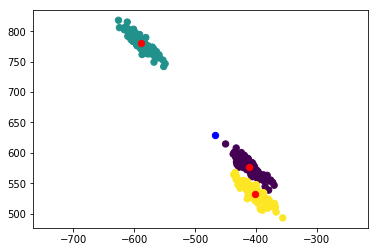

In [46]:
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=U_labels, s=40, cmap='viridis', zorder=2)
ax.scatter(Y[:, 0], Y[:, 1], c='red', s=40, cmap='viridis', zorder=2)
ax.scatter(m[0], m[1], c='blue', s=40, cmap='viridis', zorder=2)
ax.axis('equal')

In [47]:
classifier = plda.Classifier(X, np.array(U_labels))
classifier.fit_model()

In [49]:
model_mk, labels1 = classifier.model.get_means(return_labels=True)
model_ns, labels2 = classifier.model.get_ns(return_labels=True)
model_covs, labels3 = classifier.model.get_covs(return_labels=True)

model_ns

Y
model_mk

model_m = classifier.model.calc_m(model_mk,model_ns,300)

m
model_m

model_Sw = classifier.model.S_w
model_Sb = classifier.model.S_b

Sb
model_Sb

model_W = classifier.model.calc_W(model_Sw, model_Sw)
model_W

Lambda_w = classifier.model.calc_Λ_w(model_Sw, model_W)
Lambda_b = classifier.model.calc_Λ_b(model_Sw, model_W)


model_A = classifier.model.calc_A(n, Lambda_w, model_W)

A
model_A 


[100, 100, 100]

array([[-411.33144641,  577.24483548],
       [-588.18641514,  780.20852227],
       [-401.48213845,  532.54664224]])

[array([-411.33144641,  577.24483548]),
 array([-588.18641514,  780.20852227]),
 array([-401.48213845,  532.54664224])]

array([-467.,  630.])

array([-467.,  630.])

array([[ 7359.24175177, -9174.99054742],
       [-9174.99054742, 11614.28816174]])

array([[ 7359.24175177, -9174.99054742],
       [-9174.99054742, 11614.28816174]])

array([[-0.00454801,  0.13946829],
       [ 0.06398673,  0.14189915]])

array([[ 16.,   3.],
       [-14.,   4.]])

array([[-14.90300704,   6.72022863],
       [ 14.6477053 ,   0.47765629]])

In [50]:
model_Phi_w = np.matmul(model_A,model_A.T)

model_Phi_w
n/(n-1)*model_Sw

Phi_w = np.matmul(A,A.T)
Phi_w

(Phi_w - model_Phi_w)/Phi_w

X1 = X[0:100,:]
X2 = X[100:200,:]
X3 = X[200:300,:]

print('S1')
S1 = np.cov(X1[:,0],X1[:,1])
S1

print('S2')
S2 = np.cov(X2[:,0],X2[:,1])
S2

print('S3')
S3 = np.cov(X3[:,0],X3[:,1])
S3

print('AVG: (S1 + S2 + S3)/3')
(S1 + S2 + S3)/3

print('Sww')
Sww = ((S1 + S2 + S3)/300)*n/(n-1)
Sww

array([[ 267.26109172, -215.0848957 ],
       [-215.0848957 ,  214.78342597]])

array([[ 267.26109172, -215.0848957 ],
       [-215.0848957 ,  214.78342597]])

array([[ 265., -212.],
       [-212.,  212.]])

array([[-0.00853242, -0.01455139],
       [-0.01455139, -0.01312937]])

S1


array([[ 258.39973981, -209.11684931],
       [-209.11684931,  213.13423463]])

S2


array([[ 246.68206001, -206.90321073],
       [-206.90321073,  210.11300674]])

S3


array([[ 296.70147533, -229.23462706],
       [-229.23462706,  221.10303656]])

AVG: (S1 + S2 + S3)/3


array([[ 267.26109172, -215.0848957 ],
       [-215.0848957 ,  214.78342597]])

Sww


array([[ 2.69960699, -2.1725747 ],
       [-2.1725747 ,  2.16952956]])

In [87]:
n_experiments = int(np.log10(1000000) / 2)
n_experiments

n_list = [100 ** x for x in range(1, n_experiments + 1)]
n_list = np.array(n_list).astype(float)

n_list

n_dims 
n_classes = 30 #self.n_classes

Φ_w_L1_errors = []
for n in n_list:
    A, Ψ, model = experiment(int(n), n_dims, n_classes)

    Φ_w = np.matmul(A, A.T)
    Φ_w_model = np.matmul(model.A, model.A.T)

    L1_error = np.abs(Φ_w - Φ_w_model).mean()
    abs_μ = (np.abs(Φ_w).mean() + np.abs(Φ_w_model).mean()) * .5
    percent_error = L1_error / abs_μ * 100
    
    print('Testing Φ_w with {} samples: {} percent error'.format(n,
          percent_error))
    
    Φ_w_L1_errors.append(percent_error)

Y = Φ_w_L1_errors
X = [x for x in range(len(Φ_w_L1_errors))]
slope_of_error_vs_N = linregress(X, Y)[0]

3

array([1.e+02, 1.e+04, 1.e+06])

2

AssertionError: 